### aurora.py

Main program for running the OVATION PRIME 2010 model to make an aurora forecast/hindcast 
based on the PREDSTORM solar wind prediction method, or OMNI2 data for historic events.

A major update is in progress as July 2023 as we are transitioning this to the Austrian Space Weather Office.

Part of the auroramaps package
https://github.com/helioforecast/auroramaps

uses environment 'envs/aurora1.yml'

by C. Möstl, Austrian Space Weather Office, GeoSphere Austria.
twitter @chrisoutofspace
https://helioforecast.space

Contributions by Rachel L. Bailey, A. J. Weiss, Liam Kilcommons and Diana Morosan

Input parameters are given in the input.py or input_realtime.py files

This package uses a rewritten version of the ovationpyme aurora model 
by Liam Kilcommons https://github.com/lkilcommons/OvationPyme

published under GNU Lesser General Public License v3.0

-----------------------------------------------------------------------------------
#### Issues: 


core:
- run with new aurora1 environment
- check with IDL code, debuggen, both hemispheres correct?
- check with direct comparison with NOAA global images nowcast
- get flux for time -> weights for both seasons? how correctly?, compare further with ovationpyme and IDL version
- add wave flux (needs good interpolation like OP13)
- add southern hemisphere maps (with coordinate conversion etc.)
- use numba or multiprocessing somewhere further for speed? 
- multiprocessing for saving the frames does not work on MacOS! 
  maybe on linux simply use the plotting function with multiprocessing.pool
  and multiple arguments (starmap) like for the data cubes

test bottlenecks: 
    python -m cProfile -s tottime aurora_forecast.py


plotting ideas:
- transparent to white colormap so that it looks like viirs images for direct comparison
- split land on dayside / night lights on night side 
  this should work in global_predstorm_north by loading background only once
  need to figure out how to get pixels from nightshade day/night and how to plot 
  only specific pixels (but then each background image must be updated)
- indicate moon phase with astropy
- cloud cover for local location? https://pypi.org/project/weather-api/ ? at least for locations

In [2]:
import sys
import os
import getopt
import importlib
import urllib
import datetime
from dateutil import tz
from urllib.request import urlopen
from io import StringIO
import time
import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import  DateFormatter
import mpl_toolkits  
import matplotlib.dates as mdates
import seaborn as sns
from astropy.time import Time
import skimage.transform
import scipy
import aacgmv2
import pdb
from numba import njit
from multiprocessing import Pool, cpu_count, Array

from auroramaps import ovation as ao
from auroramaps import util as au

print('aacgmv2 version:',aacgmv2.__version__)


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
    from config_server import *   
    
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    #matplotlib.use('Agg') 
    from config_local import *   
 


#switches

debug_mode=1

print('imports done')


#make sure to convert the current notebook to a script
os.system('jupyter nbconvert --to script aurora.ipynb')   


start_all=time.time()


aacgmv2 version: 2.6.3
system is mac
imports done


[NbConvertApp] Converting notebook aurora.ipynb to script
[NbConvertApp] Writing 24924 bytes to aurora.py


#### Aurora Cube function

In [2]:
def make_aurora_cube_multi(ts,ec,k):
    '''
    make the aurora flux image cuves 
    multiprocessing version 
    - ts is a single datetime object into this function
    - ec the averaged Newell coupling inout
    - k the counter for the frames
    for debugging making one frame use: >> make_aurora_cube_multi(tsm[0],ecm[0],0)   
    '''
    
    print('Frame number and time:', k, '  ',ts)
    
    #################  (2a) get fluxes
        
    mlatN, mltN, fluxNd=de.get_flux_for_time(ts,ec)
    mlatN, mltN, fluxNm=me.get_flux_for_time(ts,ec)
    fluxN=fluxNd+fluxNm #+fluxNw
    #print(ts), print(ec), print(k), print('....')
    
    ################  (2b) coordinate conversion magnetic to geographic 
    #Coordinate conversion MLT to AACGM mlon/lat to geographic coordinates
    mlonN_1D_small=aacgmv2.convert_mlt(mltN[0],ts,m2a=True)
    mlonN_1D=np.tile(mlonN_1D_small,mlatN.shape[0])
    mlatN_1D=np.squeeze(mlatN.reshape(np.size(mltN),1))
    (glatN_1D, glonN_1D, galtN) = aacgmv2.convert_latlon_arr(mlatN_1D,mlonN_1D, 100,ts, method_code="A2G") #**check 100 km

    ##############  (2c) interpolate to world map 
    geo_2D=np.vstack((glatN_1D,glonN_1D)).T      #stack 2 (7680,) arrays to a single 7680,2 arrays, .T is needed
    fluxN_1D=fluxN.reshape(7680,1)   #also change flux values to 1D array

    #make a world map grid in latitude 512 pixels, longitude 1024 pixel like NOAA
    wx,wy= np.mgrid[-90:90:180/512,-180:180:360/1024]
    aimg=  np.squeeze(scipy.interpolate.griddata(geo_2D, fluxN_1D, (wx, wy), method='linear',fill_value=0))
    aimg = scipy.ndimage.gaussian_filter(aimg,sigma=(5,7),mode='wrap') #wrap means wrapping at the 180 degree edge
      
    #Array variable to be used by all processes
    ovation_img_multi[512*1024*k:512*1024*(k+1)]=aimg.reshape(512*1024)
   
    

#### Main Settings

In [3]:
if debug_mode>0:
    importlib.reload(au) #reload again while debugging
    importlib.reload(ao) #reload again while debugging

#if new background images need to be saved in auroramaps/data/wmts do this, some are included!
#au.save_gibs_earth_image('BlueMarble_NextGeneration',300)    
#au.save_gibs_earth_image('VIIRS_CityLights_2012',300)    
#au.save_gibs_earth_image('BlueMarble_NextGeneration',600)    
#au.save_gibs_earth_image('VIIRS_CityLights_2012',600)    



#get current time as datetime object in UTC, rounded to minute and time zone aware
utcnow=au.round_to_minute(datetime.datetime.now(tz=tz.tzutc())) 

print()
print('Making aurora forecasts with OVATION PRIME 2010 auroramaps')
print()
print('UTC time now:')
print(utcnow.strftime(format="%Y-%m-%d %H:%M") )
print()
    
if mode==0:
    print('mode '+str(mode)+': PREDSTORM real time')
    t0     = utcnow + datetime.timedelta(hours=past_hours)
    tend   = utcnow + datetime.timedelta(hours=future_hours)
    
if mode==1:
    print('mode '+str(mode)+': PREDSTORM local file')
    t0   = Time.strptime(start_time).datetime   #parse start time from string to datetime
    tend = Time.strptime(end_time).datetime

if mode==2:
    print('mode '+str(mode)+': OMNI2 data')
    t0   = Time.strptime(start_time).datetime   #parse start time from string to datetime
    tend = Time.strptime(end_time).datetime     

tdiff=(tend-t0)     #difference between start and end time
n_hours=int(tdiff.total_seconds()/3600)  #for how many hours the model runs

#time resolution as set in input - smallest time resolution allowed is 1 second
ts = [t0 + datetime.timedelta(seconds=i) for i in range(0, int(tdiff.total_seconds())+1,int(time_resolution*60))]

print()
print('start time:',ts[0].strftime('%Y-%m-%d %H:%M UT' ))
if mode==0: print('now time:  ',utcnow.strftime('%Y-%m-%d %H:%M UT' ))
print('end time:  ',ts[-1].strftime('%Y-%m-%d %H:%M UT' ))
print('timerange          ',n_hours, 'hours')
print('time resolution    ',time_resolution,'minutes')
print('nr of movie frames ', len(ts) )
print()

#check if all needed directories are there
if os.path.isdir('results') == False: os.mkdir('results')
if os.path.isdir('results/'+output_directory) == False: os.mkdir('results/'+output_directory)
if os.path.isdir('results/'+output_directory+'/flux_global') == False: os.mkdir('results/'+output_directory+'/flux_global')
if os.path.isdir('results/'+output_directory+'/flux_europe') == False: os.mkdir('results/'+output_directory+'/flux_europe')
if os.path.isdir('results/'+output_directory+'/flux_canada') == False: os.mkdir('results/'+output_directory+'/flux_canada')
if os.path.isdir('results/'+output_directory+'/prob_global') == False: os.mkdir('results/'+output_directory+'/prob_global')
if os.path.isdir('results/'+output_directory+'/prob_europe') == False: os.mkdir('results/'+output_directory+'/prob_europe')
if os.path.isdir('results/'+output_directory+'/prob_canada') == False: os.mkdir('results/'+output_directory+'/prob_canada')

if os.path.isdir('data/predstorm') == False: os.mkdir('data/predstorm')
if os.path.isdir('data/omni2') == False: os.mkdir('data/omni2')



inputfile='data/predstorm/predstorm_real.txt'

print(predstorm_url)


# get or set input files

if mode==0:    
   try: 
       inputfile='data/predstorm/predstorm_real.txt'
       urllib.request.urlretrieve(predstorm_url,inputfile)
       print('loaded from', predstorm_url)
   except urllib.error.URLError as e:
       print('Failed downloading ', predstorm_url,' ',e.reason)
       
##!!! or use internal server version!!!!

if mode==1:     
     inputfile=local_input_file

if mode==2:     
     au.omni_txt_generator(ts)   #make txt file from OMNI2 data in similar format as predstorm
     inputfile='auroramaps/data/predstorm/predstorm_omni.txt'
    
print('input data file:',inputfile)

print()
print('output directory: results/'+output_directory)
print('------------------------------------------------------')


Making aurora forecasts with OVATION PRIME 2010 auroramaps

UTC time now:
2023-07-21 08:38

mode 0: PREDSTORM real time

start time: 2023-07-20 20:38 UT
now time:   2023-07-21 08:38 UT
end time:   2023-07-21 10:38 UT
timerange           14 hours
time resolution     60 minutes
nr of movie frames  15

https://helioforecast.space/static/sync/predstorm_real_1m.txt
loaded from https://helioforecast.space/static/sync/predstorm_real_1m.txt
input data file: data/predstorm/predstorm_real.txt

output directory: results/aurora_test_real2
------------------------------------------------------


#### (1) Initialize OVATION

Initialize OVATION
done, took  0.06  seconds.
OVATION uses electron energy flux with diffuse + monoenergetic aurora
fluxes for southern hemisphere are currently not calculated.

Solar wind data loaded from PREDSTORM input file
[(19544.458333, -5.8 ,  6.83,  4.18, 459., 2101.84780192)
 (19544.459028, -4.3 ,  9.27,  0.44, 457., 5782.2220809 )
 (19544.459722, -4.89,  8.73,  1.33, 458., 4814.83378139) ...
 (19554.45625 ,  6.12, -5.13, -1.16, 399., 4598.57288613)
 (19554.456944,  6.11, -5.14, -1.55, 400., 5029.03142688)
 (19554.457639,  5.41, -5.99, -0.63, 403., 4465.22346896)]
2023-07-21 10:38:00+00:00
2023-07-16 10:59:00.009602+00:00
[(19558.85972222, 5.69, -5.59, -0.78, 401.2, 4487.5)
 (19558.90138889, 5.69, -5.59, -0.78, 401.2, 4487.5)
 (19558.94305556, 5.69, -5.59, -0.78, 401.2, 4487.5)
 (19558.98472222, 5.69, -5.59, -0.78, 401.2, 4487.5)
 (19559.02638889, 5.69, -5.59, -0.78, 401.2, 4487.5)
 (19559.06805556, 5.69, -5.59, -0.78, 401.2, 4487.5)
 (19559.10972222, 5.69, -5.59, -0.78, 401.2

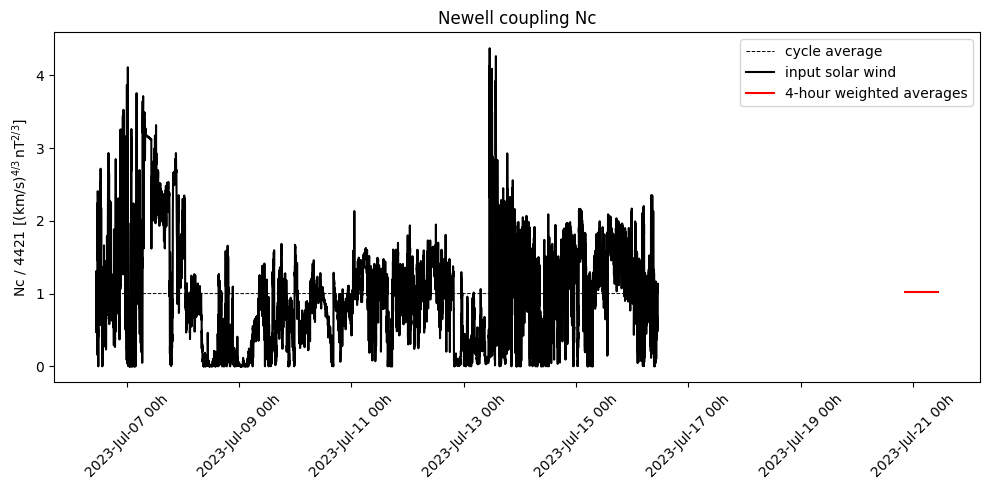

In [4]:
if debug_mode>0:
    importlib.reload(au) #reload again while debugging
    importlib.reload(ao) #reload again while debugging
########## load ovation for different types of aurora
#atype - str, ['diff','mono','wave','ions']
#         type of aurora for which to load regression coeffients
#jtype - int or str
#            1:"electron energy flux",
#            2:"ion energy flux",
#            3:"electron number flux",
#            4:"ion number flux",
#            5:"electron average energy",
#            6:"ion average energy"

jtype = 'electron energy flux'
print('Initialize OVATION')
start = time.time()
de = ao.FluxEstimator('diff', jtype)
me = ao.FluxEstimator('mono', jtype)
#we = amo.FluxEstimator('wave', jtype)
end = time.time()
print('done, took ',np.round(end - start,2),' seconds.')
print('OVATION uses',jtype,'with diffuse + monoenergetic aurora')
print('fluxes for southern hemisphere are currently not calculated.')
print()


###################### load input solar wind
l1wind=au.load_predstorm_wind(inputfile)
#convert to new matplotlib dates
l1wind.time=l1wind.time+ mdates.date2num(np.datetime64('0000-12-31'))

print('Solar wind data loaded from PREDSTORM input file')

print(l1wind)

swav=au.calc_avg_solarwind_predstorm(ts,l1wind)  # calculate average solar wind for Newell coupling 
window=int(window_minutes/time_resolution)	#when time resolution < averaging window in minutes, do moving averages
coup_cycle=4421 #average coupling for solar cycle (see e.g. Newell et al. 2010)

print(ts[-1])
print(mdates.num2date(l1wind[-1].time))

print(swav)


####################### plot current coupling, the driver behind the ovation model
fig, ax = plt.subplots(figsize=[10, 5],dpi=100)

plt.plot_date(l1wind.time,np.ones(np.size(l1wind.time)),'k--',label='cycle average',linewidth=0.7)

plt.plot_date(l1wind.time,l1wind.ec/coup_cycle,'k-', label='input solar wind')   

plt.plot_date(swav.time,swav.ec/coup_cycle,'r-',label='4-hour weighted averages',markersize=2)   

plt.title('Newell coupling Nc')
plt.ylabel(r'Nc / 4421 $\mathrm{[(km/s)^{4/3}\/nT^{2/3}]}$')
ax.xaxis.set_major_formatter( DateFormatter('%Y-%b-%d %Hh') )
plt.xticks(rotation=45)


#plot moving averages and make them if time resolution high enough
#if window > 0:
#   print('running mean used for Nc with time window +/- ',window_minutes,'minutes')
#   ec_run_mean=swav.ec
#   for i in np.arange(window,np.size(ts)-window): ec_run_mean[i]=np.mean(swav.ec[i-window:i+window])  
#   plt.plot_date(swav.time,ec_run_mean/coup_cycle,'b--',label='smoothed weighted averages' )   
   #replace Ec average by running mean
#   swav.ec=ec_run_mean
    
#ax.set_xlim([swav.time[0]-4/24,swav.time[-1]])
plt.legend()

plt.tight_layout()
fig.savefig('results/'+output_directory+'/run_newell_coupling.png',dpi=150,facecolor=fig.get_facecolor()) #save plot in outputdirectory



### (2) RUN OVATION FOR EACH TIME STEP 


In [5]:
if debug_mode>0:
    importlib.reload(au) #reload again while debugging
    importlib.reload(ao) #reload again while debugging
    
##################### (2a) get flux data cubes
print()
print('------------------------------------------------------')
print('Now make the aurora flux data cubes including all timesteps.')
print()

#depending on switch in input.py:

if calc_mode == 'single':
    print('Using single processing')
    print()
    start = time.time()
    print('clock run time start ...')
    ovation_img=ao.make_aurora_cube(ts,swav.ec,de,me) #ovation_img single processing - use ts and ec to make aurora world map; get back 512*1024 image cube
    print('... end run time clock:  ',np.round(time.time() - start,2),' sec total, per frame: ',np.round((time.time() - start)/np.size(ts),2) )


if calc_mode == 'multi':  
    print('Using multiprocessing, nr of cores',cpu_count())
    print()

    start = time.time()     #time measure indicator start
    print('clock run time start ...')

    #these variables will be used for pool.starmap
    tsm=ts; ecm=swav.ec; km=np.arange(np.size(ts))
    
    oshape = (512, 1024,np.size(ts))       #define shape of final array
    arrsize=oshape[0]*oshape[1]*oshape[2]  #define size of 1D array
    
    ovation_img_multi = Array('d', arrsize) #make 1D array to be used by the processes simultaneously for the ovation map
    p = Pool()                                              #make multiprocessing Pool object  
    res=p.starmap(make_aurora_cube_multi, zip(tsm,ecm,km))  #goes through all ts times, needs Ec and counter too
    p.close()
    p.join()
    oim=np.frombuffer(ovation_img_multi.get_obj())          #get calculated array values into 1D array

    #make final array 512*1024*size(ts) out of 1D array that is used in make_aurora_cube_multi
    ovation_img=au.reshape_ovation_img_multi(np.zeros(oshape),oim,oshape) 
 
    print('... end run time clock:  ',np.round(time.time() - start,2),' sec total, per frame: ',np.round((time.time() - start)/np.size(ts),2) )


print()
print('------------------------------------------------------')

#for testing conversion and image making - note that the image is upside down with north at bottom
#plt.close('all')
#plt.figure(1)
#plt.imshow(aimg)
#sys.exit()


##################### (2b) get lower equatorial boundary 

print('Now make equatorial boundary')
start = time.time()
print('clock run time start ... for total number of frames:', np.size(ts))

#dictionary for putting together latitude, longitude, boundary, time and flux map data for saving
eb = {'lat':np.linspace(-90,90,512), 'long':np.linspace(-180,180,1024),       \
      'boundary':np.zeros([np.size(ts),np.size(np.linspace(-180,180,1024))]), \
      'smooth':np.zeros([np.size(ts),np.size(np.linspace(-180,180,1024))]),   \
      'time': ts}#,'flux_map': ovation_img}
     
#make the equatorial boundary
eb['boundary']=au.make_equatorial_boundary(ovation_img,eb['boundary'],np.size(ts),eb['lat'],equatorial_boundary_flux_threshold) 
#the result is eb['data'] as function of longitude variable eb['long'] 
ebwin=15 #size of filter window, apply filter
eb['smooth']=au.smooth_boundary(ts,eb['boundary'],ebwin)
   
print('... end run time clock:  ',np.round(time.time() - start,2),' sec total, per frame: ',np.round((time.time() - start)/np.size(ts),2))
print('total number of frames:', np.size(ts))
print()
print('------------------------------------------------------')


#saving boundary data
eb_save_filename='results/'+output_directory+'/run_data_boundary.p' #run_data_flux_map_boundary.p'
pickle.dump(eb,open(eb_save_filename, 'wb' ))
print('Boundary data saved as '+eb_save_filename)
print()
   
        
#for debugging equatorial boundary
#plt.figure(13)
#plt.plot(eb['long'],eb['boundary'][0,:],'-r')   
#plt.plot(eb['long'],eb['smooth'][0,:],'-b')   



------------------------------------------------------
Now make the aurora flux data cubes including all timesteps.

Using single processing

clock run time start ...
Frame number and time: 0    2023-07-20 20:38:00+00:00
Frame number and time: 1    2023-07-20 21:38:00+00:00
Frame number and time: 2    2023-07-20 22:38:00+00:00
Frame number and time: 3    2023-07-20 23:38:00+00:00
Frame number and time: 4    2023-07-21 00:38:00+00:00
Frame number and time: 5    2023-07-21 01:38:00+00:00
Frame number and time: 6    2023-07-21 02:38:00+00:00
Frame number and time: 7    2023-07-21 03:38:00+00:00
Frame number and time: 8    2023-07-21 04:38:00+00:00
Frame number and time: 9    2023-07-21 05:38:00+00:00
Frame number and time: 10    2023-07-21 06:38:00+00:00
Frame number and time: 11    2023-07-21 07:38:00+00:00
Frame number and time: 12    2023-07-21 08:38:00+00:00
Frame number and time: 13    2023-07-21 09:38:00+00:00
Frame number and time: 14    2023-07-21 10:38:00+00:00
... end run time 

### (3) PLOTS and MOVIES


Make all movie frames
with single processing
marble global flux movie frame 0


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 1


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 2


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 3


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 4


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 5


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 6


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 7


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 8


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 9


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 10


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 11


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 12


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 13


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


marble global flux movie frame 14


/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(



1  different maps were produced.
All movie frames took  16.52 sec or  0.28 min, per frame 1.1  sec.

Make mp4 and gif movies (ffmpeg needs to be installed)

For all results see: results/aurora_test_real2

Run time for everything:   8.78  min; per frame:  35.13 sec



/var/folders/tr/3wb8vxgd5sj97xz5dz09q0qm0000gn/T/ipykernel_2281/2528248595.py:150: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') #for white ticks and labels, resetting the dark background for plotting the maps
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/python/miniconda3/envs/aurora1/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer

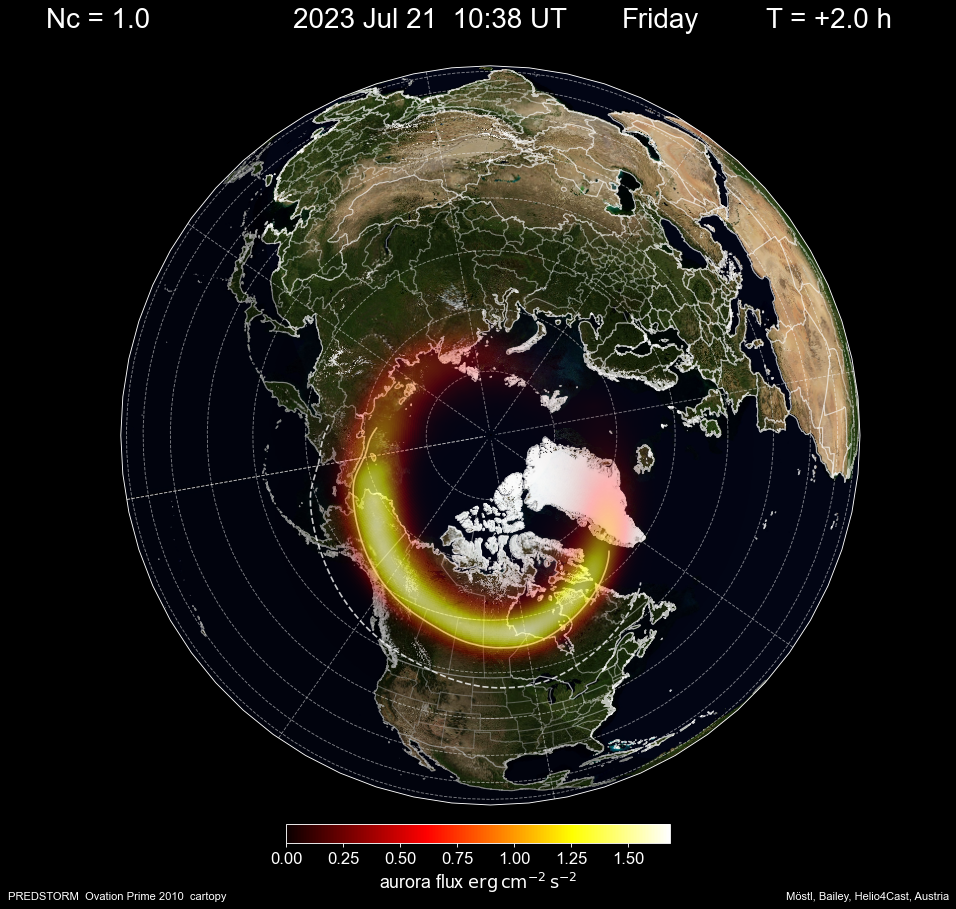

In [11]:
if debug_mode>0:
    importlib.reload(au) #reload again while debugging
    importlib.reload(ao) #reload again while debugging

############################ (3a) Make global aurora plots 
#maybe make faster with multiprocessing pool - does not work on MacOS but should on Linux
#try multiprocessing with initializer?
#https://docs.python.org/dev/library/multiprocessing.html#multiprocessing.pool.Pool

print('Make all movie frames')  
start = time.time()


if calc_mode_frame == 'single':  
    print('with single processing')  

    ############ load background image
    map_img=au.load_high_res_background(map_type)

    #flux maps
    if global_flux_map > 0:
      au.plot_ovation_single(ovation_img, ts, output_directory, eb, map_type, map_img, 'global', 'flux',utcnow,swav.ec)

    if europe_flux_map > 0:
      au.plot_ovation_single(ovation_img, ts, output_directory, eb, map_type, map_img, 'europe', 'flux',utcnow,swav.ec)
    
    if canada_flux_map > 0:
      au.plot_ovation_single(ovation_img, ts, output_directory, eb, map_type, map_img, 'canada', 'flux',utcnow,swav.ec)

    ########### same for probability maps

    #first convert flux to probability
    ovation_img_prob=au.flux_to_probability(ovation_img)

    if global_probability_map > 0:
      au.plot_ovation_single(ovation_img_prob, ts, output_directory, eb, map_type, map_img, 'global', 'prob',utcnow,swav.ec)

    if europe_probability_map > 0:
      au.plot_ovation_single(ovation_img_prob, ts, output_directory, eb, map_type, map_img, 'europe', 'prob',utcnow,swav.ec)

    if canada_probability_map > 0:
      au.plot_ovation_single(ovation_img_prob, ts, output_directory, eb, map_type, map_img, 'canada', 'prob',utcnow,swav.ec)




if calc_mode_frame == 'multi':  
    print('with multiprocessing')  

    ############ load background image
    map_img=au.load_high_res_background(map_type)

    #flux maps
    if global_flux_map > 0:
      au.plot_ovation_multi(ovation_img, ts, output_directory, eb, map_type, map_img, 'global', 'flux',utcnow,swav.ec)

    if europe_flux_map > 0:
      au.plot_ovation_multi(ovation_img, ts, output_directory, eb, map_type, map_img, 'europe', 'flux',utcnow,swav.ec)
    
    if canada_flux_map > 0:
      au.plot_ovation_multi(ovation_img, ts, output_directory, eb, map_type, map_img, 'canada', 'flux',utcnow,swav.ec)

    ########### same for probability maps

    #first convert flux to probability
    ovation_img_prob=au.flux_to_probability(ovation_img)

    if global_probability_map > 0:
      au.plot_ovation_multi(ovation_img_prob, ts, output_directory, eb, map_type, map_img, 'global', 'prob',utcnow,swav.ec)

    if europe_probability_map > 0:
      au.plot_ovation_multi(ovation_img_prob, ts, output_directory, eb, map_type, map_img, 'europe', 'prob',utcnow,swav.ec)

    if canada_probability_map > 0:
      au.plot_ovation_multi(ovation_img_prob, ts, output_directory, eb, map_type, map_img, 'canada', 'prob',utcnow,swav.ec)




######################################

number_of_maps=sum([global_flux_map, europe_flux_map, canada_flux_map, global_probability_map,europe_probability_map, canada_probability_map])
end = time.time()
print(number_of_maps, ' different maps were produced.')
print('All movie frames took ',np.round(end - start,2),'sec or ', np.round((end - start)/60,2),'min, per frame',np.round((end - start)/np.size(ts)*1/number_of_maps,2),' sec.')


################################# (3b) make movies 
print()
print('Make mp4 and gif movies (ffmpeg needs to be installed)')
print()
print('For all results see: results/'+output_directory)

 
#frame rate is set in input.py

if global_flux_map > 0:

  os.system('ffmpeg -r '+str(frame_rate)+' -i results/'+output_directory+'/flux_global/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/flux_global.mp4 -y -loglevel quiet')
  os.system('ffmpeg -r '+str(frame_rate)+' -i results/'+output_directory+'/flux_global/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/flux_global.gif -y -loglevel quiet')
  ########## convert mp4 to gif and makes smaller
  os.system('ffmpeg -i results/'+output_directory+'/flux_global.mp4  -vf scale=1000:-1 results/'+output_directory+'/flux_global_small.gif  -y -loglevel quiet ')

if europe_flux_map > 0:
  os.system(ffmpeg_path+' -r '+str(frame_rate)+' -i results/'+output_directory+'/flux_europe/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/flux_europe.mp4 -y -loglevel quiet')
  os.system(ffmpeg_path+' -r '+str(frame_rate)+' -i results/'+output_directory+'/flux_europe/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/flux_europe.gif -y -loglevel quiet')
  os.system(ffmpeg_path+' -i results/'+output_directory+'/flux_europe.mp4  -vf scale=1000:-1 results/'+output_directory+'/flux_europe_small.gif  -y -loglevel quiet ')

if canada_flux_map > 0:
  os.system(ffmpeg_path+' -r '+str(frame_rate)+' -i results/'+output_directory+'/flux_canada/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/flux_canada.mp4 -y -loglevel quiet')
  os.system(ffmpeg_path+' -r '+str(frame_rate)+' -i results/'+output_directory+'/flux_canada/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/flux_canada.gif -y -loglevel quiet')
  os.system(ffmpeg_path+' -i results/'+output_directory+'/flux_canada.mp4  -vf scale=1000:-1 results/'+output_directory+'/flux_canada_small.gif  -y -loglevel quiet ')



if global_probability_map > 0:
  #convert png to jpg ffmpeg -i aurora_%05d.png aurora_%05d.jpg -y    ///  and remove png files rm *.png -y
  #os.system(ffmpeg_path+' -i results/'+output_directory+'/prob_global/aurora_%05d.png results/'+output_directory+'/prob_global/aurora_%05d.jpg -y -loglevel quiet')
  #os.system('rm results/'+output_directory+'/prob_global/*.png -f ')

  os.system('ffmpeg -r '+str(frame_rate)+' -i results/'+output_directory+'/prob_global/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/prob_global.mp4 -y -loglevel quiet')
  os.system('ffmpeg -r '+str(frame_rate)+' -i results/'+output_directory+'/prob_global/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/prob_global.gif -y -loglevel quiet')
  os.system('ffmpeg -i results/'+output_directory+'/prob_global.mp4  -vf scale=800:-1 results/'+output_directory+'/prob_global_small.gif  -y -loglevel quiet ')

if europe_probability_map > 0:

  #os.system(ffmpeg_path+' -i results/'+output_directory+'/prob_europe/aurora_%05d.png results/'+output_directory+'/prob_europe/aurora_%05d.jpg -y -loglevel quiet')
  #os.system('rm results/'+output_directory+'/prob_europe/*.png -f ')

  os.system(ffmpeg_path+' -r '+str(frame_rate)+' -i results/'+output_directory+'/prob_europe/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/prob_europe.mp4 -y -loglevel quiet')
  os.system(ffmpeg_path+' -r '+str(frame_rate)+' -i results/'+output_directory+'/prob_europe/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/prob_europe.gif -y -loglevel quiet')
  os.system(ffmpeg_path+' -i results/'+output_directory+'/prob_europe.mp4  -vf scale=800:-1 results/'+output_directory+'/prob_europe_small.gif  -y -loglevel quiet ')

if canada_probability_map > 0:

  #os.system(ffmpeg_path+' -i results/'+output_directory+'/prob_canada/aurora_%05d.png results/'+output_directory+'/prob_canada/aurora_%05d.jpg -y -loglevel quiet')
  #os.system('rm results/'+output_directory+'/prob_canada/*.png -f ')
 
  os.system('ffmpeg -r '+str(frame_rate)+' -i results/'+output_directory+'/prob_canada/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/prob_canada.mp4 -y -loglevel quiet')
  os.system('ffmpeg -r '+str(frame_rate)+' -i results/'+output_directory+'/prob_canada/aurora_%05d.jpg -b:v 5000k -r '+str(frame_rate)+' results/'+output_directory+'/prob_canada.gif -y -loglevel quiet')
  os.system('ffmpeg -i results/'+output_directory+'/prob_canada.mp4  -vf scale=800:-1 results/'+output_directory+'/prob_canada_small.gif  -y -loglevel quiet ')



print()
print('Run time for everything:  ',np.round((time.time() - start_all)/60,2),' min; per frame: ',np.round((time.time() - start_all)/np.size(ts)*1/number_of_maps,2),'sec' )
print()


plt.style.use('seaborn-whitegrid') #for white ticks and labels, resetting the dark background for plotting the maps


##################################### END ################################################